In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")

In [2]:
cpath = 'data/map/cm_commune.json'
cm = gpd.read_file(cpath)

In [3]:
dpath = 'data/map/cm_district.json'
district = gpd.read_file(dpath)

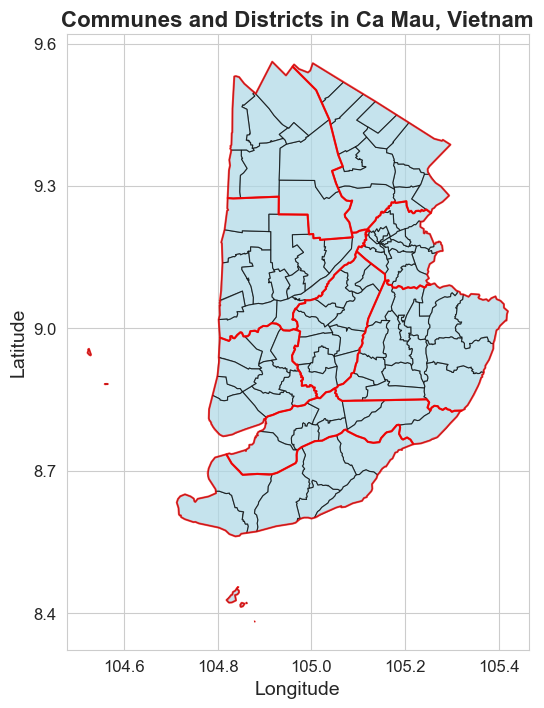

In [4]:
# Create a larger figure for better readability
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plotting communes with boundaries
cm.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.8, alpha=0.7)

# Plotting districts with boundaries
district.plot(ax=ax, color='none', edgecolor='red', linewidth=1.5, alpha=0.7)

# Enhancing the plot for publication quality
ax.set_title('Communes and Districts in Ca Mau, Vietnam', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Show the plot
plt.show()

In [12]:
dt = pd.read_excel('data/camau.xlsx')

# Dropping unnecessary columns and rows that contain NaN values
dt = dt.dropna(axis=1, how='all')  # Drop columns with all NaN values
dt = dt.dropna(axis=0, how='all')  # Drop rows with all NaN values

# Renaming columns based on the actual data structure
# The number of column names should match the number of columns in the DataFrame
column_names = dt.columns[:len(dt.columns)]  # Adjusting to the correct number of columns
dt.columns = column_names

dt.columns = ['Code', 'NAME_2', 'Level', 'Population']

In [13]:
dt['NAME_2'] = dt['NAME_2'].str.replace('Huyện ', '').str.replace('Thành phố ', '').str.replace(' ','')
dt['Population'] = 0.0

In [14]:
# dt_new = dt.copy()
# dt_new['Modified_Name'] = dt_new.apply(
#     lambda row: row['NAME_2'] + '(Thànhphố)' if row['Level'] == 'Thành phố' else row['NAME_2'], 
#     axis=1
# )

In [18]:
dt

,Code,NAME_2,Level,Population
0,964,CàMau,Thành phố,0.0
1,966,UMinh,Huyện,0.0
2,967,ThớiBình,Huyện,0.0
3,968,TrầnVănThời,Huyện,0.0
4,969,CáiNước,Huyện,0.0
5,970,ĐầmDơi,Huyện,0.0
6,971,NămCăn,Huyện,0.0
7,972,PhúTân,Huyện,0.0
8,973,NgọcHiển,Huyện,0.0


In [19]:
dt.drop(['Level'], axis = 1, inplace = True)

In [10]:
district

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,VNM.13.1_1,VNM,Vietnam,VNM.13_1,CàMau,NA,CàMau,CaMau,NA,Thànhphố,City,NA,VN.AG.CD,"MULTIPOLYGON (((105.16450 9.09150, 105.16140 9..."
1,VNM.13.2_1,VNM,Vietnam,VNM.13_1,CàMau,NA,CáiNước,CaiNuoc,NA,Huyện,District,NA,VN.BV.CC,"MULTIPOLYGON (((105.04860 8.87270, 105.04010 8..."
2,VNM.13.3_1,VNM,Vietnam,VNM.13_1,CàMau,NA,ĐầmDơi,DamDoi,NA,Huyện,District,NA,VN.AG.CP,"MULTIPOLYGON (((105.15490 8.84830, 105.06590 8..."
3,VNM.13.4_1,VNM,Vietnam,VNM.13_1,CàMau,NA,NămCăn,NamCan,NA,Huyện,District,NA,VN.AG.CT,"MULTIPOLYGON (((104.96880 8.73820, 104.96900 8..."
4,VNM.13.5_1,VNM,Vietnam,VNM.13_1,CàMau,NA,NgọcHiển,NgocHien,NA,Huyện,District,NA,VN.BR.CT,"MULTIPOLYGON (((104.84880 8.41910, 104.85160 8..."
5,VNM.13.6_1,VNM,Vietnam,VNM.13_1,CàMau,NA,PhúTân,PhuTan,NA,Huyện,District,NA,VN.DT.CT,"MULTIPOLYGON (((104.89700 8.80110, 104.88910 8..."
6,VNM.13.7_1,VNM,Vietnam,VNM.13_1,CàMau,NA,ThớiBình,ThoiBinh,NA,Huyện,District,NA,VN.HU.CT,"MULTIPOLYGON (((105.22970 9.24760, 105.22310 9..."
7,VNM.13.8_1,VNM,Vietnam,VNM.13_1,CàMau,NA,TrầnVănThời,TranVanThoi,NA,Huyện,District,NA,VN.KG.CT,"MULTIPOLYGON (((104.56140 8.88260, 104.56560 8..."
8,VNM.13.9_1,VNM,Vietnam,VNM.13_1,CàMau,NA,UMinh,UMinh,NA,Huyện,District,NA,VN.LA.CT,"MULTIPOLYGON (((105.07460 9.26910, 105.08320 9..."


In [20]:
merged_gdf = district.merge(dt, left_on='NAME_2', right_on='NAME_2', how='left')

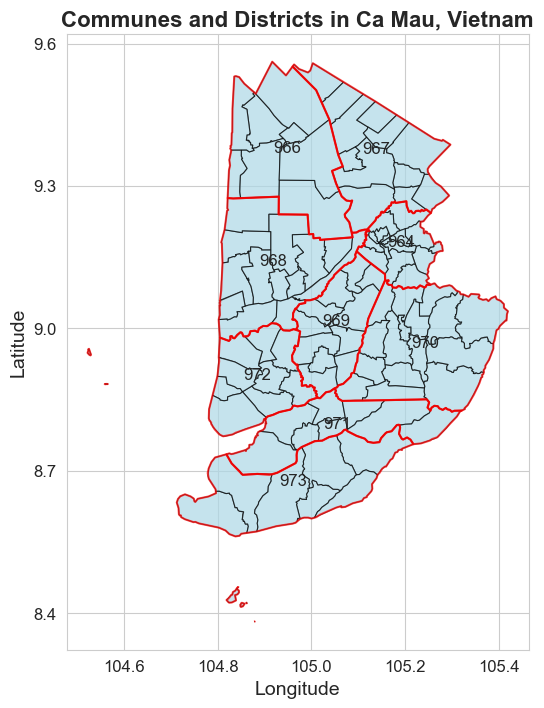

In [25]:
# Create a larger figure for better readability
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plotting communes with boundaries
cm.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=0.8, alpha=0.7)

# Plotting districts with boundaries
merged_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=1.5, alpha=0.7)
for idx, row in merged_gdf.iterrows():
    plt.annotate(text=row['Code'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=12)

# Enhancing the plot for publication quality
ax.set_title('Communes and Districts in Ca Mau, Vietnam', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))

# Show the plot
plt.show()